In [8]:
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi -L

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
GPU 0: Tesla T4 (UUID: GPU-7d71fc33-91aa-84c5-3e72-efcba8671d69)


In [9]:
!pip install scikit-surprise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from surprise import SVD, KNNBasic, Reader, Dataset, accuracy
from surprise.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
ratings_df = pd.read_csv("drive/MyDrive/moviesDataset/ratings_small.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [12]:
print("duplicates: ", sum(ratings_df.duplicated(['userId', 'movieId', 'rating'])))

duplicates:  0


In [13]:
print("missing userId: ", sum(ratings_df.isna().userId))
print("missing movieId: ", sum(ratings_df.isna().movieId))
print("missing rating: ", sum(ratings_df.isna().rating))

missing userId:  0
missing movieId:  0
missing rating:  0


In [14]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [15]:
print('total number of ratings:', int(ratings_df.describe().loc['count', 'rating']))
print('total number of distinct users:', ratings_df["userId"].nunique())
print('total number of distinct movies:', ratings_df["movieId"].nunique())

total number of ratings: 100004
total number of distinct users: 671
total number of distinct movies: 9066


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Total number of ratings')

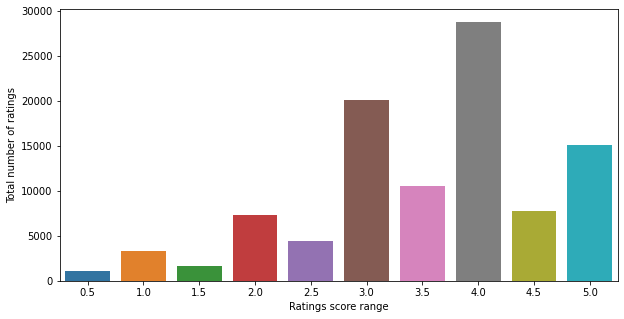

In [239]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(ratings_df.rating)
ax.set_xlabel("Ratings score range")
ax.set_ylabel("Total number of ratings")

In [17]:
userRatings = ratings_df.groupby(by='userId').rating.count()
userRatings.describe()


count     671.000000
mean      149.037258
std       231.226948
min        20.000000
25%        37.000000
50%        71.000000
75%       161.000000
max      2391.000000
Name: rating, dtype: float64

In [18]:
minRating = userRatings.describe().loc['min']
maxRating = userRatings.describe().loc['max']
avgRating = userRatings.describe().loc['mean']

print('minimum rating given by some user: ', int(minRating))
print('maximum rating given by some user: ', int(maxRating))
print('average rating given by some user: ', int(avgRating))


minimum rating given by some user:  20
maximum rating given by some user:  2391
average rating given by some user:  149


In [19]:
movieRatings = ratings_df.groupby(by='movieId').rating.count()
movieRatings.describe()


count    9066.000000
mean       11.030664
std        24.050800
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
Name: rating, dtype: float64

In [20]:
minRating = movieRatings.describe().loc['min']
maxRating = movieRatings.describe().loc['max']
avgRating = movieRatings.describe().loc['mean']

print('minimum number of ratings given to a movie: ', int(minRating))
print('maximum number of ratings given to a movie: ', int(maxRating))
print('average number of ratings given  to a movie: ', int(avgRating))

minimum number of ratings given to a movie:  1
maximum number of ratings given to a movie:  341
average number of ratings given  to a movie:  11


In [21]:
ratings = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], Reader())

In [22]:
kf = KFold(n_splits=5)
kf.split(ratings)

<generator object KFold.split at 0x7ffb1aa6ca50>

In [23]:
from surprise.model_selection import cross_validate
svd = SVD()
valDict = cross_validate(svd, ratings, measures=['RMSE', 'MAE'])

In [24]:
userKnn = KNNBasic(sim_options={'user_based': True})
valDictUserBased = cross_validate(userKnn, ratings, measures=['RMSE', 'MAE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [25]:
itemKnn = KNNBasic(sim_options={'user_based': False})
valDictItemBased = cross_validate(itemKnn, ratings, measures=['RMSE', 'MAE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [235]:
print("Probabilistic Matrix Factorization average five-fold cross validation results for RMSE:", valDict.get('test_rmse').sum() / 5)
print("Probabilistic Matrix Factorization average five-fold cross validation results for MAE:", valDict.get('test_mae').sum() / 5)

Probabilistic Matrix Factorization average five-fold cross validation results for RMSE: 0.898015908221085
Probabilistic Matrix Factorization average five-fold cross validation results for MAE: 0.6913081813882607


In [236]:
print("User-based collaborative filtering average five-fold cross validation results for RMSE:", valDictUserBased.get('test_rmse').sum() / 5)
print("User-based collaborative filtering average five-fold cross validation results for MAE:", valDictUserBased.get('test_mae').sum() / 5)

User-based collaborative filtering average five-fold cross validation results for RMSE: 0.969285693428563
User-based collaborative filtering average five-fold cross validation results for MAE: 0.7448588575464833


In [237]:
print("Item-based collaborative filtering average five-fold cross validation results for RMSE:", valDictItemBased.get('test_rmse').sum() / 5)
print("Item-based collaborative filtering average five-fold cross validation results for MAE:", valDictItemBased.get('test_mae').sum() / 5)

Item-based collaborative filtering average five-fold cross validation results for RMSE: 0.9347965721020207
Item-based collaborative filtering average five-fold cross validation results for MAE: 0.7212881386699814


In [238]:
userCosineKnn = KNNBasic(sim_options={'name': 'cosine','user_based': True})
valDictUserBasedCosine = cross_validate(userCosineKnn, ratings, measures=['RMSE', 'MAE'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [30]:
userMSDKnn = KNNBasic(sim_options={'name': 'MSD','user_based': True})
valDictUserBasedMSD = cross_validate(userMSDKnn, ratings, measures=['RMSE', 'MAE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [31]:
userPearsonKnn = KNNBasic(sim_options={'name': 'pearson_baseline','user_based': True})
valDictUserBasedPearson = cross_validate(userPearsonKnn, ratings, measures=['RMSE', 'MAE'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [32]:
itemCosineKnn = KNNBasic(sim_options={'name': 'cosine','user_based': False})
valDictItemBasedCosine = cross_validate(itemCosineKnn, ratings, measures=['RMSE', 'MAE'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
itemMSDKnn = KNNBasic(sim_options={'name': 'MSD','user_based': False})
valDictItemBasedMSD = cross_validate(itemMSDKnn, ratings, measures=['RMSE', 'MAE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [34]:
itemPearsonKnn = KNNBasic(sim_options={'name': 'pearson_baseline','user_based': False})
valDictItemBasedPearson = cross_validate(itemPearsonKnn, ratings, measures=['RMSE', 'MAE'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [35]:
print("user based collaborative filtering cosine similarity average five-fold cross validation accuracy for RMSE: {:.4f}".format(valDictUserBasedCosine.get('test_rmse').sum() / 5))
print("user based collaborative filtering cosine similarity average five-fold cross validation accuracy for MAE: {:.4f}".format(valDictUserBasedCosine.get('test_mae').sum() / 5))

user based collaborative filtering cosine similarity average five-fold cross validation accuracy for RMSE: 0.9941
user based collaborative filtering cosine similarity average five-fold cross validation accuracy for MAE: 0.7681


In [36]:
print("user based collaborative filtering MSD similarity average five-fold cross validation accuracy for RMSE: {:.4f}".format(valDictUserBasedMSD.get('test_rmse').sum() / 5))
print("user based collaborative filtering MSD similarity average five-fold cross validation accuracy for MAE: {:.4f}".format(valDictUserBasedMSD.get('test_mae').sum() / 5))

user based collaborative filtering MSD similarity average five-fold cross validation accuracy for RMSE: 0.9676
user based collaborative filtering MSD similarity average five-fold cross validation accuracy for MAE: 0.7439


In [37]:
print("user based collaborative filtering Pearson similarity average five-fold cross validation accuracy for RMSE: {:.4f}".format(valDictUserBasedPearson.get('test_rmse').sum() / 5))
print("user based collaborative filtering Pearson similarity average five-fold cross validation accuracy for MAE: {:.4f}".format(valDictUserBasedPearson.get('test_mae').sum() / 5))

user based collaborative filtering Pearson similarity average five-fold cross validation accuracy for RMSE: 0.9965
user based collaborative filtering Pearson similarity average five-fold cross validation accuracy for MAE: 0.7694


In [38]:
print("item based collaborative filtering cosine similarity average five-fold cross validation accuracy for RMSE: {:.4f}".format(valDictItemBasedCosine.get('test_rmse').sum() / 5))
print("item based collaborative filtering cosine similarity average five-fold cross validation accuracy for MAE: {:.4f}".format(valDictItemBasedCosine.get('test_mae').sum() / 5))

item based collaborative filtering cosine similarity average five-fold cross validation accuracy for RMSE: 0.9965
item based collaborative filtering cosine similarity average five-fold cross validation accuracy for MAE: 0.7757


In [39]:
print("item based collaborative filtering MSD similarity average five-fold cross validation accuracy for RMSE: {:.4f}".format(valDictItemBasedMSD.get('test_rmse').sum() / 5))
print("item based collaborative filtering MSD similarity average five-fold cross validation accuracy for MAE: {:.4f}".format(valDictItemBasedMSD.get('test_mae').sum() / 5))

item based collaborative filtering MSD similarity average five-fold cross validation accuracy for RMSE: 0.9350
item based collaborative filtering MSD similarity average five-fold cross validation accuracy for MAE: 0.7215


In [40]:
print("item based collaborative filtering pearson similarity average five-fold cross validation accuracy for RMSE: {:.4f}".format(valDictItemBasedPearson.get('test_rmse').sum() / 5))
print("item based collaborative filtering pearson similarity average five-fold cross validation accuracy for MAE: {:.4f}".format(valDictItemBasedPearson.get('test_mae').sum() / 5))

item based collaborative filtering pearson similarity average five-fold cross validation accuracy for RMSE: 0.9426
item based collaborative filtering pearson similarity average five-fold cross validation accuracy for MAE: 0.7135


In [101]:
# x1_rmse = valDictUserBasedCosine.get('test_rmse').sum() / 5
x1_rmse = valDictUserBasedCosine.get('test_rmse')
x1_mae = valDictUserBasedCosine.get('test_mae')
x2_rmse = valDictUserBasedMSD.get('test_rmse')
x2_mae = valDictUserBasedMSD.get('test_mae')
x3_rmse = valDictUserBasedPearson.get('test_rmse')
x3_mae = valDictUserBasedPearson.get('test_mae')
x4_rmse = valDictItemBasedCosine.get('test_rmse')
x4_mae = valDictItemBasedCosine.get('test_mae')
x5_rmse = valDictItemBasedMSD.get('test_rmse')
x5_mae = valDictItemBasedMSD.get('test_mae')
x6_rmse = valDictItemBasedPearson.get('test_rmse')
x6_mae = valDictItemBasedPearson.get('test_mae')

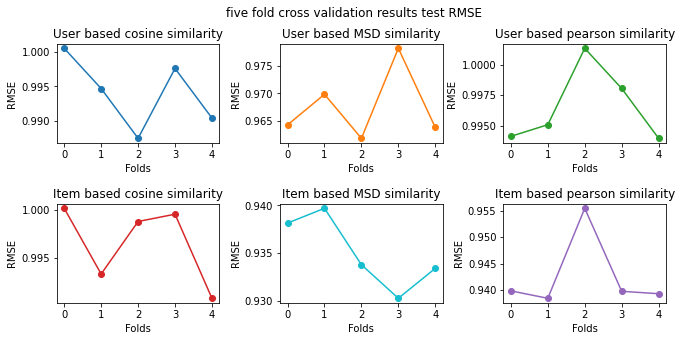

In [102]:
fig, axs = plt.subplots(2, 3, figsize=(10,5))

fig.suptitle('five fold cross validation results test RMSE')
fig.tight_layout(pad=4.0, w_pad=3.0, h_pad=4.0)

axs[0, 0].plot(x1_rmse, marker = 'o')
axs[0, 0].set_title('User based cosine similarity')
axs[0, 1].plot(x2_rmse, 'tab:orange', marker = 'o')
axs[0, 1].set_title('User based MSD similarity')
axs[0, 2].plot(x3_rmse, 'tab:green', marker = 'o')
axs[0, 2].set_title('User based pearson similarity')
axs[1, 0].plot(x4_rmse, 'tab:red', marker = 'o')
axs[1, 0].set_title('Item based cosine similarity')
axs[1, 1].plot(x5_rmse, 'tab:cyan', marker = 'o')
axs[1, 1].set_title('Item based MSD similarity')
axs[1, 2].plot(x6_rmse, 'tab:purple', marker = 'o')
axs[1, 2].set_title('Item based pearson similarity')
for ax in axs.flat:
    ax.set(ylabel='RMSE')
    ax.set(xlabel = 'Folds')

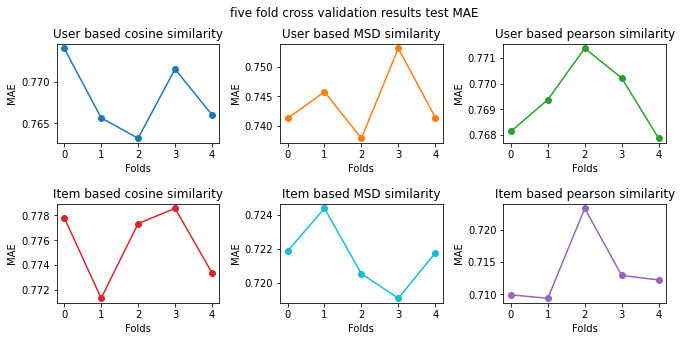

In [103]:
fig, axs = plt.subplots(2, 3, figsize=(10,5))

fig.suptitle('five fold cross validation results test MAE')
fig.tight_layout(pad=4.0, w_pad=3.0, h_pad=4.0)

axs[0, 0].plot(x1_mae, marker = 'o')
axs[0, 0].set_title('User based cosine similarity')
axs[0, 1].plot(x2_mae, 'tab:orange', marker = 'o')
axs[0, 1].set_title('User based MSD similarity')
axs[0, 2].plot(x3_mae, 'tab:green', marker = 'o')
axs[0, 2].set_title('User based pearson similarity')
axs[1, 0].plot(x4_mae, 'tab:red', marker = 'o')
axs[1, 0].set_title('Item based cosine similarity')
axs[1, 1].plot(x5_mae, 'tab:cyan', marker = 'o')
axs[1, 1].set_title('Item based MSD similarity')
axs[1, 2].plot(x6_mae, 'tab:purple', marker = 'o')
axs[1, 2].set_title('Item based pearson similarity')
for ax in axs.flat:
    ax.set(ylabel='MAE')
    ax.set(xlabel = 'Folds')

In [123]:
param_grid_user = {'k': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'sim_options': {'user_based': [True]}}#, 'sim_options': {'user_based': [False, True]}
param_grid_item = {'k': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'sim_options': {'user_based': [False]}}
knnbasic_user_gs = GridSearchCV(KNNBasic, param_grid_user, measures=['rmse', 'mae'], cv=2, n_jobs=5)
knnbasic_item_gs = GridSearchCV(KNNBasic, param_grid_item, measures=['rmse', 'mae'], cv=2, n_jobs=5)

knnbasic_user_gs.fit(ratings)
knnbasic_item_gs.fit(ratings)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [187]:
x = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
y1_user = knnbasic_user_gs.cv_results['mean_test_rmse']
y2_user = knnbasic_user_gs.cv_results['mean_test_mae']
y1_item = knnbasic_item_gs.cv_results['mean_test_rmse']
y2_item = knnbasic_item_gs.cv_results['mean_test_mae']

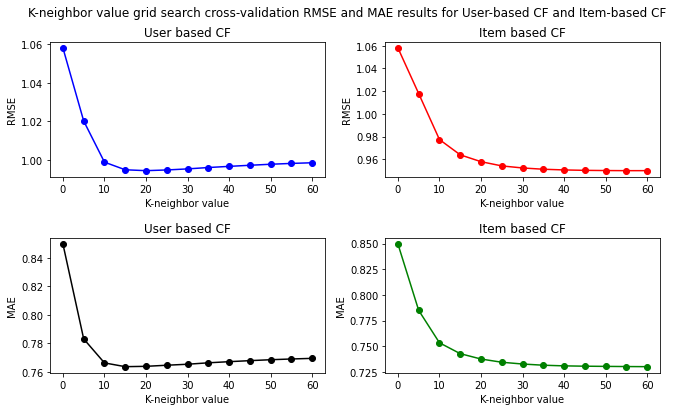

In [188]:
fig, axs = plt.subplots(2, 2, figsize=(10,6))

fig.suptitle('K-neighbor value grid search cross-validation RMSE and MAE results for User-based CF and Item-based CF')
fig.tight_layout(pad=4.0, w_pad=3.0, h_pad=4.0)

axs[0, 0].plot(x, y1_user, marker = 'o', color = 'blue')
axs[0, 0].set_title('User based CF')
axs[0, 1].plot(x, y1_item, marker = 'o', color = 'red')
axs[0, 1].set_title('Item based CF')
axs[1, 0].plot(x, y2_user, marker = 'o', color = 'black')
axs[1, 0].set_title('User based CF')
axs[1, 1].plot(x, y2_item, marker = 'o', color = 'green')
axs[1, 1].set_title('Item based CF')

axs.flat[0].set(ylabel = 'RMSE')
axs.flat[1].set(ylabel = 'RMSE')
axs.flat[2].set(ylabel = 'MAE')
axs.flat[3].set(ylabel = 'MAE')

for ax in axs.flat:
    ax.set(xlabel = 'K-neighbor value')
# Hide x labels and tick labels for top plots and y ticks for right plots.

In [189]:
knnbasic_user_gs.cv_results['param_k']

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [231]:
print("Parameter candidates for K-neighbor value:", knnbasic_user_gs.cv_results['param_k'])
print("Collaborative Filtering type:",knnbasic_user_gs.cv_results['param_sim_options'][0])
print("All RMSE values corresponding to K-neighbor candidate values:",knnbasic_user_gs.cv_results['mean_test_rmse'])
val, idx = min((val, idx) for (idx, val) in enumerate(zip(knnbasic_user_gs.cv_results['mean_test_rmse'], knnbasic_user_gs.cv_results['param_k'])))
print("Best K-neighbor value for user based CF: ", val[1], " with an error of {:.4f}".format(val[0]))

Parameter candidates for K-neighbor value: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
Collaborative Filtering type: {'user_based': True}
All RMSE values corresponding to K-neighbor candidate values: [1.05809275 1.02026745 0.99893327 0.99498224 0.99452354 0.99488505
 0.99543807 0.99614623 0.99674638 0.99731341 0.99784812 0.99827773
 0.99861747]
Best K-neighbor value for user based CF:  20  with an error of 0.9945


In [230]:
print("Parameter candidates for K-neighbor value:", knnbasic_item_gs.cv_results['param_k'])
print("Collaborative Filtering type:",knnbasic_item_gs.cv_results['param_sim_options'][0])
print("All RMSE values corresponding to K-neighbor candidate values:",knnbasic_item_gs.cv_results['mean_test_rmse'])
val, idx = min((val, idx) for (idx, val) in enumerate(zip(knnbasic_item_gs.cv_results['mean_test_rmse'], knnbasic_item_gs.cv_results['param_k'])))
print("Best K-neighbor value for user based CF: ", val[1], " with an error of {:.4f}".format(val[0]))

Parameter candidates for K-neighbor value: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
Collaborative Filtering type: {'user_based': False}
All RMSE values corresponding to K-neighbor candidate values: [1.05807182 1.01789933 0.9774002  0.96393962 0.95791602 0.95418982
 0.95238323 0.95125847 0.95064767 0.9502815  0.95011312 0.95000518
 0.95001357]
Best K-neighbor value for user based CF:  55  with an error of 0.9500
